In [20]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
s3_prefix = "s3://aegovan-data/pubmed_asbtract/predictions_largescale_ppimulticlass-bert-f1-2021-05-10-10_2021-07-01/"
s3_output_prefix = "{}_summary/".format(s3_prefix.rstrip("/"))
s3_data ="s3://aegovan-data/human_output/human_interactions_ppi_v2.json"

In [3]:
label_order = ["acetylation", "methylation", "phosphorylation", "dephosphorylation", "ubiquitination", "deubiquitination",  "other"]
pos_labels = list( filter(lambda x: x != 'other', label_order))
label_order_key = lambda x:  label_order.index(x)

label_title_map = {"other" : "Negative class"}

In [4]:
local_temp = "../temp"
local_temp_pred_dir = os.path.join( local_temp, "pred_results")
local_temp_wk_dir = os.path.join( local_temp, "wk")

In [ ]:
!rm -rf $local_temp
!mkdir -p $local_temp_pred_dir
!mkdir -p $local_temp_wk_dir

In [5]:
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os


def upload_file(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """

        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    input_tuples = ( (f,  s3_prefix) for f in glob.glob("{}/*".format(local_dir)))
    
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, input_tuples)
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_s3file_size(bucket, key):
    s3 = boto3.client('s3')
    response = s3.head_object(Bucket=bucket, Key=key)
    size = response['ContentLength']
    return size
    
def download_files_min_files(s3_prefix, local_dir, min_file_size=310, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix) if get_s3file_size(s3_bucket, s3_key) > min_file_size )
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        


In [ ]:
%%time

download_files(s3_prefix, local_temp_pred_dir)

In [6]:
!ls -l $local_temp_dir | wc -l

      21


In [7]:
threshold_config = {'acetylation': {('confidence_std', 'count'): 5.0,
  ('confidence_std', 'mean'): 0.20221626758575403,
  ('confidence_std', 'std'): 0.010931891264366925,
  ('confidence_std', 'min'): 0.186287313699722,
  ('confidence_std', '25%'): 0.19900196790695102,
  ('confidence_std', '50%'): 0.20083150267601002,
  ('confidence_std', '75%'): 0.21166041493415802,
  ('confidence_std', 'max'): 0.21330013871192902,
  ('confidence', 'count'): 5.0,
  ('confidence', 'mean'): 0.5777932286262508,
  ('confidence', 'std'): 0.017217069729986746,
  ('confidence', 'min'): 0.555882334709167,
  ('confidence', '25%'): 0.572159707546234,
  ('confidence', '50%'): 0.57360166311264,
  ('confidence', '75%'): 0.5849224925041191,
  ('confidence', 'max'): 0.602399945259094},
 'dephosphorylation': {('confidence_std', 'count'): 29.0,
  ('confidence_std', 'mean'): 0.21133935400124204,
  ('confidence_std', 'std'): 0.07727310272430898,
  ('confidence_std', 'min'): 0.11373741179704601,
  ('confidence_std', '25%'): 0.141093701124191,
  ('confidence_std', '50%'): 0.18553803861141202,
  ('confidence_std', '75%'): 0.255215793848037,
  ('confidence_std', 'max'): 0.41554290056228604,
  ('confidence', 'count'): 29.0,
  ('confidence', 'mean'): 0.8063360175182077,
  ('confidence', 'std'): 0.13017405501056736,
  ('confidence', 'min'): 0.32787588238716103,
  ('confidence', '25%'): 0.7709274291992181,
  ('confidence', '50%'): 0.8457427024841301,
  ('confidence', '75%'): 0.8899683952331541,
  ('confidence', 'max'): 0.914224922657012},
 'deubiquitination': {('confidence_std', 'count'): 2.0,
  ('confidence_std', 'mean'): 0.1863851696252815,
  ('confidence_std', 'std'): 0.002637275825296506,
  ('confidence_std', 'min'): 0.184520334005355,
  ('confidence_std', '25%'): 0.18545275181531826,
  ('confidence_std', '50%'): 0.1863851696252815,
  ('confidence_std', '75%'): 0.18731758743524476,
  ('confidence_std', 'max'): 0.18825000524520802,
  ('confidence', 'count'): 2.0,
  ('confidence', 'mean'): 0.4542059451341625,
  ('confidence', 'std'): 0.010661192844799884,
  ('confidence', 'min'): 0.446667343378067,
  ('confidence', '25%'): 0.45043664425611474,
  ('confidence', '50%'): 0.4542059451341625,
  ('confidence', '75%'): 0.4579752460122103,
  ('confidence', 'max'): 0.461744546890258},
 'methylation': {('confidence_std', 'count'): 9.0,
  ('confidence_std', 'mean'): 0.20187029076947058,
  ('confidence_std', 'std'): 0.011129410572280824,
  ('confidence_std', 'min'): 0.185736715793609,
  ('confidence_std', '25%'): 0.19583970308303802,
  ('confidence_std', '50%'): 0.19923907518386802,
  ('confidence_std', '75%'): 0.210324048995971,
  ('confidence_std', 'max'): 0.21908366680145203,
  ('confidence', 'count'): 9.0,
  ('confidence', 'mean'): 0.7966000636418656,
  ('confidence', 'std'): 0.01647822043812186,
  ('confidence', 'min'): 0.7693868875503541,
  ('confidence', '25%'): 0.780769705772399,
  ('confidence', '50%'): 0.798503041267395,
  ('confidence', '75%'): 0.809625148773193,
  ('confidence', 'max'): 0.8169981241226191},
 'other': {('confidence_std', 'count'): 1116.0,
  ('confidence_std', 'mean'): 0.015799599189941234,
  ('confidence_std', 'std'): 0.0407698558038574,
  ('confidence_std', 'min'): 0.0008510624757030001,
  ('confidence_std', '25%'): 0.00117629769374575,
  ('confidence_std', '50%'): 0.0021780409151680004,
  ('confidence_std', '75%'): 0.007007123087532501,
  ('confidence_std', 'max'): 0.303181886672973,
  ('confidence', 'count'): 1116.0,
  ('confidence', 'mean'): 0.9903799230800303,
  ('confidence', 'std'): 0.026711376001797505,
  ('confidence', 'min'): 0.5133088827133171,
  ('confidence', '25%'): 0.9944566637277598,
  ('confidence', '50%'): 0.9974353015422815,
  ('confidence', '75%'): 0.998221039772033,
  ('confidence', 'max'): 0.9985265731811521},
 'phosphorylation': {('confidence_std', 'count'): 139.0,
  ('confidence_std', 'mean'): 0.09348429794416534,
  ('confidence_std', 'std'): 0.11442879568269237,
  ('confidence_std', 'min'): 0.006378921680152001,
  ('confidence_std', '25%'): 0.013172945939004001,
  ('confidence_std', '50%'): 0.034169171005487005,
  ('confidence_std', '75%'): 0.13673919439315751,
  ('confidence_std', 'max'): 0.469867438077926,
  ('confidence', 'count'): 139.0,
  ('confidence', 'mean'): 0.9306538756802781,
  ('confidence', 'std'): 0.09291076266425286,
  ('confidence', 'min'): 0.548133730888366,
  ('confidence', '25%'): 0.9297615289688106,
  ('confidence', '50%'): 0.9758448600769041,
  ('confidence', '75%'): 0.98560282588005,
  ('confidence', 'max'): 0.990909934043884},
 'ubiquitination': {('confidence_std', 'count'): 5.0,
  ('confidence_std', 'mean'): 0.1845212131738658,
  ('confidence_std', 'std'): 0.010037806334405529,
  ('confidence_std', 'min'): 0.174075484275817,
  ('confidence_std', '25%'): 0.177953422069549,
  ('confidence_std', '50%'): 0.18058878183364802,
  ('confidence_std', '75%'): 0.19217012822628002,
  ('confidence_std', 'max'): 0.197818249464035,
  ('confidence', 'count'): 5.0,
  ('confidence', 'mean'): 0.5571501374244686,
  ('confidence', 'std'): 0.07332355556921501,
  ('confidence', 'min'): 0.42922157049179005,
  ('confidence', '25%'): 0.5765218138694761,
  ('confidence', '50%'): 0.579930007457733,
  ('confidence', '75%'): 0.58320677280426,
  ('confidence', 'max'): 0.616870522499084}}

In [8]:
def get_summary_df(local_temp_pred_dir, use_std=True, conf_percentile="50%", confidence_std_percentile="50%"):
    list_df_high_quality = []
    list_df_summary = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        

        list_df_summary.append(df[["prediction", "confidence", "confidence_std", "pubmedId", "participant1Id", "participant2Id", "participant1Name", "participant2Name"]])

        # Filter below threshold items
        high_quality_frames = []
        for k,t in threshold_config.items():
            conf_median = t[('confidence', conf_percentile)]
            conf_std_median = t[('confidence_std', confidence_std_percentile)]
            
            # HQ filter query
            qry = "prediction == '{}' and confidence >= {} and confidence_std <= {}" .format(k, conf_median, conf_std_median)
            if not use_std:
                qry = "prediction == '{}' and confidence >= {} " .format(k, conf_median)
           
            high_quality_frames.append(df.query(qry))

        high_quality_df = pd.concat(high_quality_frames)

        list_df_high_quality.append(high_quality_df)

    
    return pd.concat(list_df_high_quality), pd.concat(list_df_summary)



In [9]:
%%time 


df_high_quality_threshold, df_summary = get_summary_df (local_temp_pred_dir, use_std=True)

CPU times: user 2min 12s, sys: 7.03 s, total: 2min 19s
Wall time: 2min 21s


In [10]:
%%time

df_summary.groupby([ "participant1Id", "participant2Id", "prediction"])\
    .filter(lambda x: len(x)>1)\
    .groupby([ "participant1Id", "participant2Id", "prediction"])\
    .count()\
    .describe()

CPU times: user 24.5 s, sys: 440 ms, total: 24.9 s
Wall time: 25 s


,confidence,confidence_std,pubmedId,participant1Name,participant2Name
count,149405.000000,149405.000000,149405.000000,149405.000000,149405.000000
mean,8.051404,8.051404,8.051404,8.051404,8.051404
std,47.437537,47.437537,47.437537,47.437537,47.437537
min,2.000000,2.000000,2.000000,2.000000,2.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000
max,10229.000000,10229.000000,10229.000000,10229.000000,10229.000000


In [11]:
%%time

df_summary.groupby([ "participant1Id", "participant2Id", "prediction"])\
    .count()\
    .describe()

CPU times: user 2.43 s, sys: 143 ms, total: 2.57 s
Wall time: 2.57 s


,confidence,confidence_std,pubmedId,participant1Name,participant2Name
count,546588.000000,546588.000000,546588.000000,546588.000000,546588.000000
mean,2.927439,2.927439,2.927439,2.927439,2.927439
std,24.999565,24.999565,24.999565,24.999565,24.999565
min,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000,2.000000,2.000000
max,10229.000000,10229.000000,10229.000000,10229.000000,10229.000000


In [12]:
%%time

df_summary.groupby([ "participant1Id", "participant2Id", "prediction"])\
    .filter(lambda x: len(x)>3)\
    .sort_values(by = [ "participant1Id", "participant2Id", "prediction"])\
    .sample(n=10)

CPU times: user 22.5 s, sys: 301 ms, total: 22.8 s
Wall time: 22.8 s


,prediction,confidence,confidence_std,pubmedId,participant1Id,participant2Id,participant1Name,participant2Name
2166,phosphorylation,0.757204,0.365881,11527723,P06239,P12931,Lck,pp60(c-Src
493,phosphorylation,0.819687,0.266068,29615433,P03372,P04626,estrogen receptor,HER2
341,phosphorylation,0.357181,0.432788,18971943,Q13087,Q96HE7,protein disulphide isomerase,Ero1alpha
192,phosphorylation,0.645420,0.425782,26228833,P43115,P43116,EP3,EP2
1751,phosphorylation,0.488000,0.335786,8786427,P20783,P23560,neurotrophin-3,brain-derived neurotrophic factor
1450,dephosphorylation,0.354174,0.372903,19559678,P01375,P05362,tumor necrosis factor,intercellular adhesion molecule (ICAM)-1
1858,phosphorylation,0.587196,0.422652,15257108,P01375,P35228,tumor necrosis factor,inducible nitric oxide synthase
2266,phosphorylation,0.786640,0.380231,15934808,A6NKG5,P23297,MART-1,S100
271,phosphorylation,0.679240,0.402543,28959039,P28482,P28562,p38,MAP phosphatases (MKP)-1
2278,phosphorylation,0.639300,0.403641,18670907,P01019,P03950,angiotensin II,Ang


In [13]:
%%time

df_high_quality_threshold.groupby([ "participant1Id", "participant2Id", "prediction"])\
    .filter(lambda x: len(x)>1)\
    .groupby([ "participant1Id", "participant2Id", "prediction"])\
    .count()\
    .describe()

CPU times: user 240 ms, sys: 16.4 ms, total: 256 ms
Wall time: 254 ms


,pubmedId,participant1Name,participant2Name,abstract,normalised_abstract,annotations,gene_to_uniprot_map,normalised_abstract_annotations,other,phosphorylation,dephosphorylation,methylation,ubiquitination,acetylation,deubiquitination,confidence,confidence_std,raw_confidence
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,3.105360,3.105360,3.105360,3.105360,3.105360,3.105360,3.105360,3.105360,3.105360,3.105360,3.105360,3.105360,3.105360,3.105360,3.105360,3.105360,3.105360,3.105360
std,2.666317,2.666317,2.666317,2.666317,2.666317,2.666317,2.666317,2.666317,2.666317,2.666317,2.666317,2.666317,2.666317,2.666317,2.666317,2.666317,2.666317,2.666317
min,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
75%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
max,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000


In [14]:
%%time

df_high_quality_threshold.groupby([ "participant1Id", "participant2Id", "prediction"])\
    .filter(lambda x: len(x)>1)\
    .groupby([  "prediction"])[  "prediction"]\
    .count()

CPU times: user 185 ms, sys: 1.23 ms, total: 186 ms
Wall time: 185 ms


prediction
dephosphorylation       4
methylation             4
phosphorylation      1672
Name: prediction, dtype: int64

In [15]:
%%time

df_high_quality_threshold.groupby([ "participant1Id", "participant2Id", "prediction"])\
    .filter(lambda x: len(x)>1 )\
    .sample(n=10)

CPU times: user 181 ms, sys: 1.12 ms, total: 182 ms
Wall time: 181 ms


,pubmedId,participant1Id,participant1Name,participant2Id,participant2Name,abstract,normalised_abstract,annotations,gene_to_uniprot_map,normalised_abstract_annotations,...,phosphorylation,dephosphorylation,methylation,ubiquitination,acetylation,deubiquitination,prediction,confidence,confidence_std,raw_confidence
858,26814137,P14902,"Indoleamine 2,3-dioxygenase",P40763,STAT3,"In pregnancy, trophoblast proliferation, migra...","In pregnancy, trophoblast proliferation, migra...","[{'start': '315', 'end': '342', 'name': 'Indol...","{'3620': 'P14902', '6774': 'P40763', '4318': '...","[{'charOffset': 315, 'len': 6, 'text': 'P14902...",...,0.984799,0.002216,0.002387,0.002432,0.001886,0.002174,phosphorylation,0.984799,0.018282,"[0.9731011986732481, 0.994819581508636, 0.9936..."
2444,15265592,P49840,GSK3alpha,P49841,GSK3beta,Progressive supranuclear palsy (PSP) is a neur...,Progressive supranuclear palsy (PSP) is a neur...,"[{'start': '380', 'end': '388', 'name': 'GSK3b...","{'2932': 'P49841', '2931': 'P49840'}","[{'charOffset': 380, 'len': 6, 'text': 'P49841...",...,0.985327,0.001863,0.001964,0.001265,0.001276,0.001296,phosphorylation,0.985327,0.013234,"[0.992735505104064, 0.9725797176361081, 0.9742..."
1634,15063271,P10415,Bcl-2,Q92934,Bad,Expression of Bcl-2 family proteins and activa...,Expression of P10415 family proteins and activ...,"[{'start': '14', 'end': '19', 'name': 'Bcl-2',...","{'596': 'P10415', '836': 'P42574', '572': 'Q92...","[{'charOffset': 14, 'len': 6, 'text': 'P10415'...",...,0.980826,0.001286,0.002123,0.001810,0.002101,0.001420,phosphorylation,0.980826,0.014786,"[0.9923296570777891, 0.95756846666336, 0.99436..."
2124,21131356,O43524,FOXO3a,P31749,Akt,The activity of mammalian target of rapamycin ...,The activity of P42345 (P42345) complexes regu...,"[{'start': '16', 'end': '45', 'name': 'mammali...","{'2475': 'P42345', '207': 'P31749', '2309': 'O...","[{'charOffset': 16, 'len': 6, 'text': 'P42345'...",...,0.983341,0.001992,0.002426,0.001872,0.002651,0.001629,phosphorylation,0.983341,0.021811,"[0.9950889945030211, 0.9951727986335751, 0.995..."
892,15754328,P04637,p53,P06493,cdc-2,Hepatocellular carcinoma (HCC) is a major heal...,Hepatocellular carcinoma (HCC) is a major heal...,"[{'start': '224', 'end': '232', 'name': 'patie...","{'7157': 'P04637', '3339': 'P98160', '1026': '...","[{'charOffset': 328, 'len': 6, 'text': 'P04637...",...,0.976878,0.002471,0.001717,0.001762,0.001752,0.001414,phosphorylation,0.976878,0.024935,"[0.9618515968322751, 0.9770350456237791, 0.993..."
788,23410755,P01138,nerve growth factor,P04629,TrkA,"In autocrine cells, both a ligand and its rece...","In autocrine cells, both a ligand and its rece...","[{'start': '183', 'end': '187', 'name': 'PC12'...","{'4803': 'P01138', '4914': 'P04629', '4804': '...","[{'charOffset': 209, 'len': 6, 'text': 'P01138...",...,0.986511,0.001594,0.001395,0.001084,0.001188,0.001007,phosphorylation,0.986511,0.012675,"[0.9950537085533141, 0.994608283042907, 0.9964..."
931,12506122,P36507,MEK2,Q02750,MEK1,The MAPKKs MEK1 and MEK2 are activated by phos...,The MAPKKs Q02750 and P36507 are activated by ...,"[{'start': '11', 'end': '15', 'name': 'MEK1', ...","{'5604': 'Q02750', '5605': 'P36507', '5594': '...","[{'charOffset': 11, 'len': 6, 'text': 'Q02750'...",...,0.978673,0.002050,0.001825,0.001423,0.001576,0.001243,phosphorylation,0.978673,0.019521,"[0.967106223106384, 0.970646798610687, 0.98810..."
816,17949899,P20827,ephrinA1,P29317,EphA2,The objective of this study was to understand ...,The objective of this study was to understand ...,"[{'start': '96', 'end': '101', 'name': 'EphA2'...","{'1969': 'P29317', '1942': 'P20827'}","[{'charOffset': 96, 'len': 6, 'text': 'P29317'...",...,0.982737,0.002075,0.002509,0.001278,0.001706,0.001348,phosphorylation,0.982737,0.015201,"[0.9711927175521851, 0.9615567922592161, 0.995..."
1686,15289331,P31749,Akt,P49841,glycogen synthase kinase-3beta,"EBV is associated with the epithelial cancer, ...","EBV is associated with the epithel

In [16]:
df_high_quality = df_high_quality_threshold.groupby([ "participant1Id", "participant2Id", "prediction"])\
    .filter(lambda x: len(x)>1 )

In [17]:
import matplotlib.gridspec as gridspec

import numpy as np

def box_plot_prediction_confidence(df, df_high_quality, subplot_spec, title_prefix="", set_title=True):
    interaction_types = label_order
    
    num_plots = len(interaction_types)
    gs = gridspec.GridSpecFromSubplotSpec(1, len(label_order), subplot_spec=subplot_spec)
    
    for i, interaction in enumerate(interaction_types):
        df_interaction = df.query(f"prediction == '{interaction}'")
        df_interaction_high_quality = df_high_quality.query(f"prediction == '{interaction}'")
        
        if len(df_interaction) == 0: continue
        
        ax = fig.add_subplot(gs[0, i])
    
    
        # Rename columns
        new_column_names = {"confidence":"c", 
                           "confidence_std" : "v"
                            }
        df_interaction = df_interaction.rename(columns = new_column_names)
        df_interaction_high_quality=df_interaction_high_quality.rename(columns = new_column_names)
        
        
        # Style and formatting..
        
        if set_title:
            ax.set_title("{}{}\nT={} (HQ={}%)".format( title_prefix,
                                               label_title_map.get(interaction, interaction).title(),
                                               len(df_interaction),
                                               round(100 * len(df_interaction_high_quality)/len(df_interaction),2)                
                                              )
                        )
        ax.set_ylim(0,1)
        
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        
        ax.spines['bottom'].set_color('grey')
        ax.spines['top'].set_color('grey') 
        ax.spines['right'].set_color('grey')
        ax.spines['left'].set_color('grey')
        
        
        # Plot violin plot        
        ax.violinplot(df_interaction[["c", "v" ]],  showmeans=True )
        if len(df_interaction_high_quality) > 0:
            ax.violinplot(df_interaction_high_quality[["c", "v" ]],  showmeans=True )
        
        
        x_labels = ['C', 'V']
        
        ax.xaxis.set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(x_labels) + 1))
        ax.set_xticklabels(x_labels)
        ax.set_xlim(0.25, len(x_labels) + 0.75)
        
        
       



        


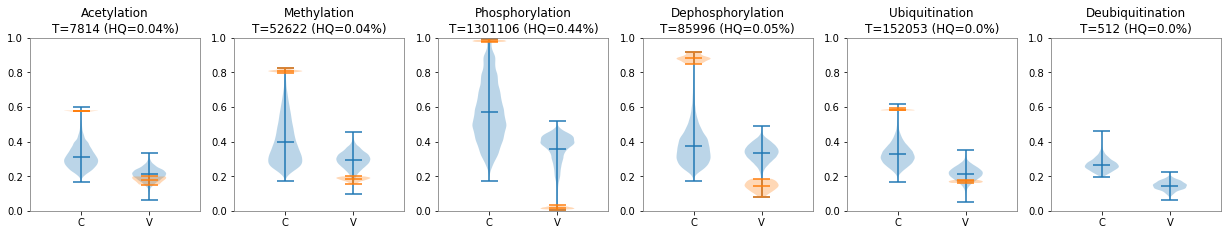

In [21]:
fig = plt.figure(figsize=(25 , 7))
gs = fig.add_gridspec(nrows=2)

box_plot_prediction_confidence(df_summary, df_high_quality_threshold, gs[0])

plt.savefig("largescaleprediction_distribution.pdf", bbox_inches="tight")

In [22]:
df_summary.shape

(1600103, 8)

In [23]:
df_summary.groupby("prediction").describe().T

prediction             acetylation  dephosphorylation  deubiquitination  \
confidence     count  7.814000e+03       8.599600e+04      5.120000e+02   
               mean   3.127081e-01       3.770867e-01      2.661245e-01   
               std    6.387505e-02       1.049603e-01      3.535714e-02   
               min    1.679264e-01       1.721430e-01      1.925499e-01   
               25%    2.649182e-01       2.990283e-01      2.418651e-01   
               50%    3.041625e-01       3.621136e-01      2.620904e-01   
               75%    3.534613e-01       4.338882e-01      2.849126e-01   
               max    6.006500e-01       9.174241e-01      4.617445e-01   
confidence_std count  7.814000e+03       8.599600e+04      5.120000e+02   
               mean   2.105105e-01       3.360322e-01      1.450459e-01   
               std    3.650847e-02       5.060654e-02      2.551565e-02   
               min    6.070806e-02       8.261938e-02      6.051787e-02   
               25%    1.862821e-01       3.025211e-01      1.279653e-01   
               50%    2.113768e-01       3.384592e-01      1.461324e-01   
               75%    2.349800e-01       3.727958e-01      1.622773e-01   
               max    3.348950e-01       4.914492e-01      2.244747e-01   
pubmedId       count  7.814000e+03       8.599600e+04      5.120000e+02   
               mean   1.827663e+07       1.606554e+07      2.032314e+07   
               std    7.745668e+06       8.035124e+06      6.941911e+06   
               min    1.140000e+03       4.500000e+02      7.305440e+05   
               25%    1.193176e+07       9.572470e+06      1.642670e+07   
               50%    1.934024e+07       1.642783e+07      2.158914e+07   
               75%    2.474807e+07       2.285067e+07      2.592945e+07   
               max    3.052525e+07       3.052454e+07      3.047828e+07   

prediction             methylation  phosphorylation  ubiquitination  
confidence     count  5.262200e+04     1.301106e+06    1.520530e+05  
               mean   3.968556e-01     5.697892e-01    3.257748e-01  
               std    1.271545e-01     1.720569e-01    5.966913e-02  
               min    1.719247e-01     1.720937e-01    1.636227e-01  
               25%    2.950942e-01     4.383482e-01    2.821410e-01  
               50%    3.685337e-01     5.513105e-01    3.204003e-01  
               75%    4.801754e-01     6.917892e-01    3.631499e-01  
               max    8.269717e-01     9.907943e-01    6.149684e-01  
confidence_std count  5.262200e+04     1.301106e+06    1.520530e+05  
               mean   2.942120e-01     3.583199e-01    2.139932e-01  
               std    4.816604e-02     8.640525e-02    3.875029e-02  
               min    9.499982e-02     6.206166e-03    5.022085e-02  
               25%    2.619969e-01     3.160160e-01    1.879721e-01  
               50%    2.956794e-01     3.818166e-01    2.151539e-01  
               75%    3.279718e-01     4.198187e-01    2.412301e-01  
               max    4.528537e-01     5.203627e-01    3.500032e-01  
pubmedId       count  5.262200e+04     1.301106e+06    1.520530e+05  
               mean   1.699505e+07     1.709475e+07    1.856129e+07  
               std    8.248884e+06     7.860495e+06    7.368797e+06  
               min    5.600000e+01     6.000000e+01    1.755000e+03  
               25%    1.037267e+07     1.067120e+07    1.242423e+07  
               50%    1.791162e+07     1.753581e+07    1.943586e+07  
               75%    2.399712e+07     2.367649e+07    2.462559e+07  
               max    3.052509e+07     3.052527e+07    3.052516e+07

In [24]:
df_high_quality_threshold.groupby(["prediction"])[["prediction", "confidence", "confidence_std"]].describe().T

prediction            acetylation  dephosphorylation  methylation  \
confidence     count     3.000000          42.000000    23.000000   
               mean      0.577767           0.881514     0.809059   
               std       0.003032           0.019359     0.006814   
               min       0.574266           0.849926     0.799061   
               25%       0.576875           0.868206     0.805046   
               50%       0.579485           0.881211     0.807967   
               75%       0.579518           0.892138     0.811937   
               max       0.579551           0.917424     0.826972   
confidence_std count     3.000000          42.000000    23.000000   
               mean      0.180173           0.142870     0.183372   
               std       0.024727           0.028311     0.012262   
               min       0.152028           0.082619     0.154916   
               25%       0.171055           0.124469     0.176801   
               50%       0.190082           0.146389     0.186139   
               75%       0.194245           0.166641     0.191214   
               max       0.198408           0.184901     0.199017   

prediction            phosphorylation  ubiquitination  
confidence     count      5721.000000        5.000000  
               mean          0.982277        0.584419  
               std           0.003611        0.005255  
               min           0.975850        0.580424  
               25%           0.979242        0.580954  
               50%           0.982206        0.583207  
               75%           0.985243        0.584096  
               max           0.990794        0.593414  
confidence_std count      5721.000000        5.000000  
               mean          0.017550        0.169572  
               std           0.006499        0.007941  
               min           0.006206        0.160962  
               25%           0.012284        0.162796  
               50%           0.016811        0.170951  
               75%           0.022234        0.172560  
               max           0.034128        0.180589

In [25]:
df_high_quality.groupby(["prediction"])[["prediction", "confidence", "confidence_std"]].describe().T

prediction            dephosphorylation  methylation  phosphorylation
confidence     count           4.000000     4.000000      1672.000000
               mean            0.892749     0.805350         0.982143
               std             0.017481     0.008237         0.003594
               min             0.872069     0.799076         0.975851
               25%             0.883297     0.800123         0.979168
               50%             0.892811     0.802572         0.982003
               75%             0.902263     0.807799         0.985159
               max             0.913303     0.817178         0.990151
confidence_std count           4.000000     4.000000      1672.000000
               mean            0.126084     0.182040         0.017812
               std             0.016314     0.011766         0.006601
               min             0.101740     0.168332         0.006206
               25%             0.124490     0.175417         0.012379
               50%             0.133238     0.181959         0.017043
               75%             0.134832     0.188582         0.022736
               max             0.136121     0.195912         0.034107

In [26]:
download_file(s3_data, local_temp_wk_dir)

In [27]:
data_file = os.path.join(local_temp_wk_dir, s3_data.split("/")[-1])
data_training_full_df = pd.read_json(data_file)

In [28]:
data_training_full_df.shape

(3381, 7)

In [29]:
data_training_full_df.head(n=2)

,interactionId,interactionType,isNegative,participants,pubmedId,pubmedTitle,pubmedabstract
0,1585513,phosphorylation,false,"[{'uniprotid': 'Q10728', 'alias': [['mypt1_rat...",17126281,None,Zipper-interacting protein kinase (ZIP kinase)...
1,1585516,phosphorylation,false,"[{'uniprotid': 'O43293-1', 'alias': [['o43293-...",17126281,None,Zipper-interacting protein kinase (ZIP kinase)...


In [30]:
data_training_full_df["participants"].sample(n=2).iloc[0]

[{'uniprotid': 'Q8WTS6',
  'alias': [['setd7_human'],
   ['Histone-lysine N-methyltransferase SETD7'],
   ['SETD7'],
   ['KIAA1717'],
   ['SET7'],
   ['KMT7'],
   ['SET9'],
   ['Histone H3-K4 methyltransferase SETD7'],
   ['SET domain-containing protein 7'],
   ['SET7/9'],
   ['Lysine N-methyltransferase 7']],
  'alternative_uniprots': ['B5WWL3', 'Q4W5A9', 'Q9C0E6', 'Q0VAH3']},
 {'uniprotid': 'Q04207',
  'alias': [['tf65_mouse'],
   ['Transcription factor p65'],
   ['Nuclear factor NF-kappa-B p65 subunit'],
   ['Rela'],
   ['Nfkb3'],
   ['Nuclear factor of kappa light polypeptide gene enhancer in B-cells 3']],
  'alternative_uniprots': ['Q62025']}]

In [31]:
def get_partipants_key_raw(participants):
    """
    Example input
    [{'uniprotid': 'P19388',
  'alias': [['rpab1_human'],
   ['DNA-directed RNA polymerases I, II, and III subunit RPABC1'],
   ['POLR2E'],
   ['DNA-directed RNA polymerase II subunit E'],
   ['RPB5 homolog'],
   ['DNA-directed RNA polymerase II 23 kDa polypeptide'],
   ['XAP4']],
  'alternative_uniprots': ['Q6PIH5', 'Q9BT06', 'O43380', 'B2R6L4', 'D6W5Y1']},
 {'uniprotid': 'Q96SB4',
  'alias': [['srpk1_human'],
   ['SRSF protein kinase 1'],
   ['Serine/arginine-rich protein-specific kinase 1'],
   ['SFRS protein kinase 1'],
   ['SRPK1']],
  'alternative_uniprots': ['Q5R365', 'Q5R364', 'B4DS61', 'Q8IY12', 'Q12890']}]
    """
    participant_uniprot = []
    for p in participants:
        
        participant_uniprot.append(str(p["uniprotid"]))
        
        
    result = get_partipants_key(participant_uniprot)
    
    return result

def get_partipants_key(list_uniprot):
    participant_uniprot=sorted(filter (lambda x: x is not None, list_uniprot))
    
    result = "#".join(participant_uniprot)
    
    return result


def is_in_training(df, training_df):
    training_participants = training_df["participants"].apply(get_partipants_key_raw)
    df_particpiants = df[["participant2Id", "participant1Id"]].apply(lambda x : get_partipants_key([x["participant2Id"],x["participant2Id"]]), axis=1)
    return df_particpiants.isin(training_participants)

def is_in_training_pubmed(df, training_df):
    return df["pubmedId"].isin(training_df["pubmedId"])

In [34]:
df_high_quality["PubmedInTrainingData"] = is_in_training( df_high_quality, data_training_full_df)

In [35]:
df_high_quality[~df_high_quality.PubmedInTrainingData].shape

(1649, 22)

In [36]:
c_df=pd.DataFrame(df_summary.query("prediction != 'other'")\
                  .groupby([ "prediction"]).size()).rename(columns={0: "all_count"})
tmp_df = pd.DataFrame(df_high_quality[~df_high_quality.PubmedInTrainingData]\
      .groupby('prediction').size())\
      .rename(columns={0: "filter_count"})

tmp_df = tmp_df.merge(c_df, left_index=True,  right_index=True, how="right")\
      [[ "all_count", "filter_count"]]

print(tmp_df.to_latex( index=True))

tmp_df

\begin{tabular}{lrr}
\toprule
{} &  all\_count &  filter\_count \\
prediction        &            &               \\
\midrule
acetylation       &       7814 &           NaN \\
dephosphorylation &      85996 &           2.0 \\
deubiquitination  &        512 &           NaN \\
methylation       &      52622 &           4.0 \\
phosphorylation   &    1301106 &        1643.0 \\
ubiquitination    &     152053 &           NaN \\
\bottomrule
\end{tabular}



,all_count,filter_count
prediction,,
acetylation,7814,NaN
dephosphorylation,85996,2.0
deubiquitination,512,NaN
methylation,52622,4.0
phosphorylation,1301106,1643.0
ubiquitination,152053,NaN


In [37]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

plt.rcParams.update({'font.size': 12})

In [38]:
df_high_quality.sample(n=10)

,pubmedId,participant1Id,participant1Name,participant2Id,participant2Name,abstract,normalised_abstract,annotations,gene_to_uniprot_map,normalised_abstract_annotations,other,phosphorylation,dephosphorylation,methylation,ubiquitination,acetylation,deubiquitination,prediction,confidence,confidence_std,raw_confidence,PubmedInTrainingData
2024,15610030,P04637,p53,Q00987,Murine double-minute clone 2 protein,Murine double-minute clone 2 protein (MDM2) is...,Q00987 (Q00987) is an E3 ubiquitin ligase that...,"[{'start': '0', 'end': '36', 'name': 'Murine d...","{'4193': 'Q00987', '7157': 'P04637'}","[{'charOffset': 0, 'len': 6, 'text': 'Q00987'}...",0.005835,0.980513,0.003781,0.002458,0.003130,0.002388,0.001895,phosphorylation,0.980513,0.019811,"[0.9934151172637941, 0.977349579334259, 0.9943...",False
1455,19726736,P31749,AKT,P98170,XIAP,The PIK3/AKT pathway plays an important role i...,The P48736/P31749 pathway plays an important r...,"[{'start': '4', 'end': '8', 'name': 'PIK3', 't...","{'5294': 'P48736', '207': 'P31749', '331': 'P9...","[{'charOffset': 4, 'len': 6, 'text': 'P48736'}...",0.003541,0.988895,0.001896,0.001765,0.001421,0.001239,0.001243,phosphorylation,0.988895,0.007448,"[0.9741766452789301, 0.9765026569366451, 0.993...",False
1017,26209050,P04637,Tumor protein 53,Q07812,B cell lymphoma 2-associated X protein,"In India, Epithelial ovarian cancer has emerge...","In India, Epithelial ovarian cancer has emerge...","[{'start': '97', 'end': '102', 'name': 'women'...","{'7157': 'P04637', '581': 'Q07812'}","[{'charOffset': 104, 'len': 6, 'text': 'P04637...",0.005716,0.983606,0.001434,0.002784,0.002615,0.001808,0.002036,phosphorylation,0.983606,0.012832,"[0.988499104976654, 0.9781855344772331, 0.9932...",False
1045,30052036,P35568,insulin receptor substrate 1,Q14289,protein kinase B,Exosomes are nanosized extracellular vesicles ...,Exosomes are nanosized extracellular vesicles ...,"[{'start': '308', 'end': '313', 'name': 'human...","{'3667': 'P35568', '2185': 'Q14289'}","[{'charOffset': 757, 'len': 6, 'text': 'P35568...",0.009192,0.978943,0.002395,0.002191,0.002954,0.002340,0.001985,phosphorylation,0.978943,0.020159,"[0.956022918224334, 0.98562091588974, 0.995899...",False
995,25698201,P23443,p70S6 kinase,P42345,mammalian target of rapamycin,The phosphorylation of p70S6 kinase (p70S6K) r...,The phosphorylation of P23443 (P23443) represe...,"[{'start': '23', 'end': '35', 'name': 'p70S6 k...","{'6198': 'P23443', '2475': 'P42345'}","[{'charOffset': 23, 'len': 6, 'text': 'P23443'...",0.012507,0.980751,0.001525,0.001703,0.001105,0.001258,0.001152,phosphorylation,0.980751,0.019645,"[0.9337413311004631, 0.9784915447235101, 0.992...",False
1227,8180318,P01583,interleukin (IL)-1,P05231,IL-6,The inhibitory effect of interleukin (IL)-1 on...,The inhibitory effect of P01583 on thyroid cel...,"[{'start': '25', 'end': '43', 'name': 'interle...","{'3552': 'P01583', '3569': 'P05231'}","[{'charOffset': 25, 'len': 6, 'text': 'P01583'...",0.004432,0.985316,0.001335,0.002771,0.002178,0.001789,0.002177,phosphorylation,0.985316,0.008865,"[0.9746103882789611, 0.9764461517333981, 0.994...",False
1888,16650822,P19367,HK1,P52789,HK2,Two-component systems (TCSs) are the major sig...,Two-component systems (TCSs) are the major sig...,"[{'start': '156', 'end': '188', 'name': 'Mycob...","{'3098': 'P19367', '3099': 'P52789'}","[{'charOffset': 218, 'len': 6, 'text': '887847...",0.007225,0.982441,0.001753,0.002055,0.002497,0.002004,0.002025,phosphorylation,0.982441,0.026569,"[0.9943101406097411, 0.993124425411224, 0.9945...",False
1063,9675079,P40189,gp130,P40763,signal transducer and activator of transcripti...,Propagation of embryonic stem (ES) cells with ...,Propagation of embryonic stem (ES) cells with ...,"[{'start': '102', 'end': '128', 'name': 'leuke...","{'3976': 'P15018', '3572': 'P40189', '1437': '...","[{'charOffset': 102, 'len': 6, 'text': 'P15018...",0.007178,0.984933,0.001837,0.001510,0.001687,0.001613,0.001243,phosphorylation,0.984933,0.011764,"[0.9

In [39]:
df_high_quality["unique_gene_count"] = df_high_quality["gene_to_uniprot_map"].apply(lambda x: len(x))

In [40]:
df_high_quality.groupby("prediction")[["confidence","unique_gene_count"]].describe()

confidence                                          \
                       count      mean       std       min       25%   
prediction                                                             
dephosphorylation        4.0  0.892749  0.017481  0.872069  0.883297   
methylation              4.0  0.805350  0.008237  0.799076  0.800123   
phosphorylation       1672.0  0.982143  0.003594  0.975851  0.979168   

                                                unique_gene_count            \
                        50%       75%       max             count      mean   
prediction                                                                    
dephosphorylation  0.892811  0.902263  0.913303               4.0  3.250000   
methylation        0.802572  0.807799  0.817178               4.0  2.250000   
phosphorylation    0.982003  0.985159  0.990151            1672.0  2.928828   

                                                        
                        std  min   25%  50%   75%  max  
prediction                                              
dephosphorylation  0.957427  2.0  2.75  3.5  4.00  4.0  
methylation        0.500000  2.0  2.00  2.0  2.25  3.0  
phosphorylation    1.166183  2.0  2.00  3.0  4.00  8.0

In [42]:
predictions_above_threshold_file = "predictions_above_threshold.json"
df_high_quality_threshold.to_json(predictions_above_threshold_file, orient='records')

In [43]:
upload_file(predictions_above_threshold_file, "{}/".format(s3_output_prefix.rstrip("/")))

In [44]:
predictions_highquality_file = "predictions_above_threshold.json"
df_high_quality.to_json(predictions_highquality_file, orient='records')
upload_file(predictions_highquality_file, "{}/".format(s3_output_prefix.rstrip("/")))

In [45]:
samples_per_interaction = 30

samples_subset = df_high_quality.query("PubmedInTrainingData == False")\
                .groupby('prediction', group_keys=False)\
                .apply(lambda x: x.sample(min(len(x), samples_per_interaction),random_state=45))

samples_subset.groupby(["prediction"])["prediction"].count()

prediction
dephosphorylation     2
methylation           4
phosphorylation      30
Name: prediction, dtype: int64

In [46]:
samples_subset.columns

Index(['pubmedId', 'participant1Id', 'participant1Name', 'participant2Id',
       'participant2Name', 'abstract', 'normalised_abstract', 'annotations',
       'gene_to_uniprot_map', 'normalised_abstract_annotations', 'other',
       'phosphorylation', 'dephosphorylation', 'methylation', 'ubiquitination',
       'acetylation', 'deubiquitination', 'prediction', 'confidence',
       'confidence_std', 'raw_confidence', 'PubmedInTrainingData',
       'unique_gene_count'],
      dtype='object')

In [48]:
samples_subset.sample(n=5)

,pubmedId,participant1Id,participant1Name,participant2Id,participant2Name,abstract,normalised_abstract,annotations,gene_to_uniprot_map,normalised_abstract_annotations,other,phosphorylation,dephosphorylation,methylation,ubiquitination,acetylation,deubiquitination,prediction,confidence,confidence_std,raw_confidence,PubmedInTrainingData,unique_gene_count
917,9148953,P06493,Cdc2,P30291,Wee1,Wee1 tyrosine kinase regulates mitosis by carr...,P30291 tyrosine kinase regulates mitosis by ca...,"[{'start': '0', 'end': '4', 'name': 'Wee1', 't...","{'7465': 'P30291', '983': 'P06493'}","[{'charOffset': 0, 'len': 6, 'text': 'P30291'}...",0.005539,0.976998,0.005175,0.002983,0.003468,0.002598,0.003239,phosphorylation,0.976998,0.023496,"[0.926474094390869, 0.974580287933349, 0.99421...",False,2
1420,1840422,P17677,B-50,Q92686,neurogranin,The neuronal phosphoprotein B-50/GAP-43 has be...,The neuronal phosphoprotein P17677/P17677 has ...,"[{'start': '28', 'end': '32', 'name': 'B-50', ...","{'2596': 'P17677', '4900': 'Q92686'}","[{'charOffset': 28, 'len': 6, 'text': 'P17677'...",0.007816,0.978067,0.001880,0.002973,0.003767,0.002471,0.003026,phosphorylation,0.978067,0.028580,"[0.9858201742172241, 0.8994225859642021, 0.981...",False,2
333,19877273,P23443,S6K1,P42345,mTOR,"The mTOR kinase controls cell growth, prolifer...","The P42345 kinase controls cell growth, prolif...","[{'start': '4', 'end': '8', 'name': 'mTOR', 't...","{'2475': 'P42345', '6198': 'P23443'}","[{'charOffset': 4, 'len': 6, 'text': 'P42345'}...",0.009647,0.978661,0.003203,0.002132,0.002787,0.001666,0.001904,phosphorylation,0.978661,0.029182,"[0.9946770668029781, 0.9927319884300231, 0.995...",False,2
669,24151879,P04637,p53,Q96KQ7,G9a,"Protein lysine methyltransferase G9a, which ca...","Protein lysine methyltransferase Q96KQ7, which...","[{'start': '33', 'end': '36', 'name': 'G9a', '...","{'10919': 'Q96KQ7', '7157': 'P04637'}","[{'charOffset': 33, 'len': 6, 'text': 'Q96KQ7'...",0.004906,0.015148,0.021254,0.817178,0.041534,0.052105,0.047876,methylation,0.817178,0.177778,"[0.875878870487213, 0.43388986587524403, 0.918...",False,2
927,28539327,P01375,TNF,Q13546,RIPK1,TNF is a potent inducer of inflammation due to...,P01375 is a potent inducer of inflammation due...,"[{'start': '0', 'end': '3', 'name': 'TNF', 'ty...","{'7124': 'P01375', '8737': 'Q13546', '11035': ...","[{'charOffset': 0, 'len': 6, 'text': 'P01375'}...",0.012315,0.979188,0.001919,0.001548,0.001923,0.001569,0.001537,phosphorylation,0.979188,0.028353,"[0.9901095628738401, 0.9762859344482421, 0.992...",False,7


### Create ground truth training jobs

In [49]:
import json
import json
def create_manifest_file(df, outfile):
    items = df.to_dict(orient='records' )
    with open(outfile , "w") as f:
        for item in items:
            # Write without new lines
            item_m  = {}
            item_m["source"] = json.dumps(item)
            f.write(json.dumps(item_m).replace("\n", "\t"))
            f.write("\n")

In [50]:
def create_manifest_per_interaction(samples_subset_df, s3_output_prefix):
    samples_subset_file = "predictions_sample_subset.json"
    samples_subset_df.to_json(samples_subset_file, orient='records')
    upload_file(samples_subset_file, "{}/".format(s3_output_prefix.rstrip("/")))


    manifest_file = "predictions_sample_subset.mainfest"
    create_manifest_file(samples_subset_df, manifest_file)
    upload_file(manifest_file, "{}/".format(s3_output_prefix.rstrip("/")))

    # Create one manifest file per interaction type
    m_files=[]
    for i in list(samples_subset_df["prediction"].unique()):
        manifest_file = "predictions_sample_subset_{}.mainfest".format(i)
        s3_manifest_file = "{}/{}".format(s3_output_prefix.rstrip("/"), manifest_file)
        create_manifest_file(samples_subset_df.query("prediction == '{}'".format(i)), manifest_file)
        upload_file(manifest_file, s3_manifest_file)
        
        m_files.append(s3_manifest_file)
    return m_files


In [51]:
s3_manifests = create_manifest_per_interaction(samples_subset, s3_output_prefix)

In [52]:
import boto3
import sagemaker

In [53]:
from datetime import datetime

def create_groundtruth_labelling_job(s3_manifest, s3_gt_output, s3_template, pre_lambda, post_lambda, role, workforce_name, job_name, label_attribute_name="prediction", workforce_type= "private-crowd" ):
    client = boto3.client('sagemaker')
    
    sagemaker_session = sagemaker.Session()
    account_id =  boto3.client('sts').get_caller_identity().get('Account')
    region = boto3.session.Session().region_name
    
    workforce_arn = "arn:aws:sagemaker:{}:{}:workteam/{}/{}".format(region, account_id, workforce_type, workforce_name)
    role_arn = "arn:aws:iam::{}:role/{}".format( account_id,  role)
    pre_lambda_arn = "arn:aws:lambda:{}:{}:function:{}".format(region, account_id,  pre_lambda)
    post_lambda_arn = "arn:aws:lambda:{}:{}:function:{}".format(region, account_id,  post_lambda)
    
    num_workers_per_object = 1
    task_time_limit_sec = 60  * 60 * 5
    task_availablity_sec =60  * 60 * 24 * 10
    
    job = client.create_labeling_job(LabelingJobName=job_name
                                    ,LabelAttributeName = label_attribute_name
                                    ,InputConfig = {
                                        "DataSource": {
                                            'S3DataSource': {
                                            'ManifestS3Uri': s3_manifest
                                            }
                                        }
                                        
                                    }
                                  ,OutputConfig={
                                        'S3OutputPath': s3_gt_output
                                    }

                                  , RoleArn = role_arn
                                  , HumanTaskConfig={
                                    'WorkteamArn': workforce_arn,
                                    'UiConfig': {
                                        'UiTemplateS3Uri': s3_template
                                    },
                                    'PreHumanTaskLambdaArn': pre_lambda_arn,
                                    'TaskKeywords': [
                                        'PPI',
                                    ],
                                    'TaskTitle': 'Verify PPI extraction for protein {}'.format(s3_manifest.split("/")[-1]),
                                    'TaskDescription': 'Verifies PPi extraction',
                                    'NumberOfHumanWorkersPerDataObject': num_workers_per_object,
                                    'TaskTimeLimitInSeconds': task_time_limit_sec,
                                    'TaskAvailabilityLifetimeInSeconds': task_availablity_sec,
                                    'MaxConcurrentTaskCount': 10,
                                    'AnnotationConsolidationConfig': {
                                        'AnnotationConsolidationLambdaArn': post_lambda_arn
                                    }
                                }
                            )
    
    return job
    
    

def create_groundtruth_labelling_multiple_jobs(lst_s3_manifests, s3_gt_output, s3_template, pre_lambda, post_lambda, role, workforce_name, job_prefix ="ppi", label_attribute_name="class"):
    job_prefix = "{}-{}".format(job_prefix , datetime.now().strftime("%Y%m%d%H%M%S"))
    for s3_manifest in lst_s3_manifests:
        job_name = "{}-{}".format( job_prefix, s3_manifest.split("/")[-1].split("_")[-1].split(".")[0])
        print(f"Creating job {job_name}")
        create_groundtruth_labelling_job(s3_manifest, s3_gt_output, s3_template, pre_lambda, post_lambda, role, workforce_name, job_name)

In [54]:
import urllib.request

def download_template(template_url):
    with urllib.request.urlopen(template_url) as f:
        html = f.read().decode('utf-8')

    with open("template.html", "w") as f:
        f.write(html)
    
download_template('http://raw.githubusercontent.com/elangovana/ppi-sagemaker-groundtruth-verification/main/src/template/template.html')

In [55]:
role_name = "service-role/AmazonSageMaker-ExecutionRole-20210104T161547"
pre_lambda="Sagemaker-ppipreprocessing"
post_lambda="sagemaker-ppipostprocessing"
s3_gt_output = "{}/gt_output/".format(s3_prefix.rstrip("/"))
workforce_name = "ppi-team"
s3_template_file = "{}/template.html".format(s3_prefix.rstrip("/"))

In [56]:


upload_file("template.html", s3_template_file )
create_groundtruth_labelling_multiple_jobs (s3_manifests,
                                            s3_gt_output, 
                                            s3_template_file,
                                            pre_lambda, 
                                            post_lambda, 
                                            role_name,
                                            workforce_name)

Creating job ppi-20210809205317-dephosphorylation
Creating job ppi-20210809205317-methylation
Creating job ppi-20210809205317-phosphorylation


## Verify the ground truth jobs

In [ ]:
ground_truth_jobs = [
"ppi-20210619153907-ubiquitination",
"ppi-20210619153907-phosphorylation",
"ppi-20210619153907-methylation",
"ppi-20210619153907-dephosphorylation",
"ppi-20210619153907-acetylation"
]

In [ ]:
import pandas, json,   ast


def load_manifest_file(manifest_file):
    with open(manifest_file) as f:
        df_list = []
        for l in  f.readlines():
            record = json.loads(l)
            result = json.loads(record["source"])
            meta_key = list([k for k,_ in  record.items() if k.endswith( "-metadata" )])[0]
            result ["human_result"] = record[meta_key.replace("-metadata","")]["result"]
            
            df_list.append(result)
        return df_list
    
def load_manifests(manifest_files):
    l = []
    if isinstance (manifest_files, str): manifest_files=[manifest_files]
    for f in manifest_files:
        l.extend(load_manifest_file(f))
        
    return pd.DataFrame(l)
    
def load_manifests_s3(s3_manifest_files, local_dir):
    l = []
    if isinstance (s3_manifest_files, str): manifest_files=[s3_manifest_files]
    for s3_file in s3_manifest_files:
        manifest_file=os.path.join(local_dir , s3_file.split("/")[-1] )
        download_file(s3_file, local_dir)
        l.extend(load_manifest_file(manifest_file))
        
    return pd.DataFrame(l)

In [ ]:
s3_gt_output_mainifests = ["{}/{}/manifests/output/output.manifest".format(s3_gt_output.rstrip("/"),j) for j in ground_truth_jobs]
df = load_manifests_s3(s3_gt_output_mainifests,local_temp)

In [ ]:
df_gt_summary = df.groupby(["prediction", "human_result"])["human_result"].count().unstack().fillna(0).T
df_gt_summary["total"] = df_gt_summary.sum(axis=1)
df_gt_summary.loc["total"]= df_gt_summary.sum(axis=0)

In [ ]:
df_gt_summary